<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 6 - Modelo LSTM</h3>
    <h3>Ejercicio 3_sincronico</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno, Drago Braian <p>
</div>

**Modelo LSTM**  

Las LSTM son un tipo especial de redes recurrentes. La característica principal de las redes recurrentes es que la información puede persistir introduciendo bucles en el diagrama de la red, por lo que, básicamente, pueden «recordar» estados previos y utilizar esta información para decidir cuál será el siguiente.  
Esta característica las hace muy adecuadas para manejar series cronológicas. Mientras las redes recurrentes estándar pueden modelar dependencias a corto plazo (es decir, relaciones cercanas en la serie cronológica), las LSTM pueden aprender dependencias largas, por lo que se podría decir que tienen una «memoria» a más largo plazo.  

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

**Esquema simplificado de la estructura LSTM:**

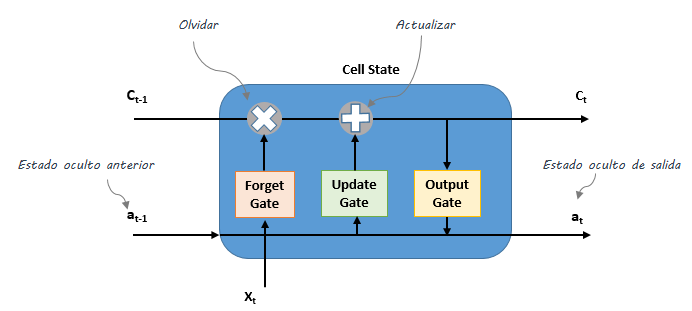

**Objetivo del Ejercicio**: Tomando como referencia los datos de un Instituto de Biogeoquímica que contiene el registro histórico de diferentes variables climáticas, queremos elaborar modelos predictivos basados en Redes LSTM para predecir la temperatura.  

*Info: La Sociedad Max Planck es una de las organizaciones de investigación más importantes de Alemania. La sociedad cuenta actualmente con 84 institutos y organismos que se dedican a la investigación básica de las ciencias naturales, biología, humanidades y ciencias sociales al servicio del interés público.*

**Variables del dataset:**  

*p (mbar):* presión del aire en milibars  
*T (degC):* temperatura del aire en °C  
*Tpot (K):* temperatura potencial  
*Tdew (degC):* temperatura de punto de rocío (a la cual el vapor de agua se condensa)  
*rh (%):* humedad relativa  
*VPmax (mbar):* presión de vapor de agua de saturación  
*VPact (mbar):* presión de vapor de agua real  
*VPdef (mbar):* déficit de presión de vapor de agua  
*sh (g/kg):* humedad específica  
*H2OC (mmol/mol):* nivel de concentración del vapor de agua  
*rho (g/m**3):* densidad del aire  
*wv (m/s):* velocidad del viento  
*max. wv (m/s):* velocidad del viento máxima  
*wd (deg):* dirección del viento  
*SWDR (W/m²):* Environmental variables-global radiation  

**La variable a predecir es la temperatura (columna T (degC) de nuestro dataset).**

Origenes de datos: https://www.bgc-jena.mpg.de/wetter/weather_data.html

**Carga de Librerías**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

**Carga de datos**

In [ ]:
url='https://raw.githubusercontent.com/braiandrago/AST/main/temp.csv'
temperatura = pd.read_csv(url, encoding='latin-1')
temperatura.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.07.2023 00:10:00    984.99     15.21    289.61        15.19    99.9   
1  01.07.2023 00:20:00    985.00     15.03    289.43        15.03   100.0   
2  01.07.2023 00:30:00    984.98     14.86    289.26        14.64    98.6   
3  01.07.2023 00:40:00    984.91     14.91    289.32        14.47    97.2   
4  01.07.2023 00:50:00    984.92     14.77    289.17        14.46    98.0   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  wv (m/s)  \
0         17.31         17.29          0.02      10.99  ...      1.02   
1         17.11         17.11          0.00      10.88  ...      0.47   
2         16.92         16.69          0.24      10.61  ...      1.06   
3         16.98         16.50          0.48      10.49  ...      1.29   
4         16.83         16.49          0.34      10.48  ...      1.45   

   max. wv (m/s)  wd (deg)  rain (mm)  raining (s)  SWDR (W/m²)  \
0           1.32     208.1        0.0          0.0          0.0   
1           1.11     219.9        0.0          0.0          0.0   
2           1.77     226.7        0.0          0.0          0.0   
3           1.89     242.1        0.0          0.0          0.0   
4           2.06     238.6        0.0          0.0          0.0   

   PAR (µmol/m²/s)  max. PAR (µmol/m²/s)  Tlog (degC)  CO2 (ppm)  
0              0.0                   0.0        27.10      450.3  
1              0.0                   0.0        27.05      451.0  
2              0.0                   0.0        26.97      439.4  
3              0.0                   0.0        26.87      438.2  
4              0.0                   0.0        26.73      440.0  

[5 rows x 22 columns]

Que observamos? Frecuencia de registro de datos?

# Procesamiento de datos

In [ ]:
temperatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9174 entries, 0 to 9173
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             9174 non-null   object 
 1   p (mbar)              9174 non-null   float64
 2   T (degC)              9174 non-null   float64
 3   Tpot (K)              9174 non-null   float64
 4   Tdew (degC)           9174 non-null   float64
 5   rh (%)                9174 non-null   float64
 6   VPmax (mbar)          9174 non-null   float64
 7   VPact (mbar)          9174 non-null   float64
 8   VPdef (mbar)          9174 non-null   float64
 9   sh (g/kg)             9174 non-null   float64
 10  H2OC (mmol/mol)       9174 non-null   float64
 11  rho (g/m**3)          9173 non-null   float64
 12  wv (m/s)              9174 non-null   float64
 13  max. wv (m/s)         9174 non-null   float64
 14  wd (deg)              9173 non-null   float64
 15  rain (mm)            

En los siguientes pasos:  
-Convertimos la columna Date Time al formato datetime  
-Fijamos esta columna datetime como el nuevo índice de nuestro DataFrame      
-Orden cronológico ascendente

In [ ]:
temperatura['Date Time'].dtype #otra forma de verificar

dtype('O')

In [ ]:
temperatura['datetime'] = pd.to_datetime(
    temperatura['Date Time'],
    format = '%d.%m.%Y %H:%M:%S'
)

In [ ]:
temperatura = temperatura.set_index('datetime')

In [ ]:
temperatura.sort_index(inplace=True)

In [ ]:
temperatura = temperatura.drop(columns=['Date Time'])

In [ ]:
temperatura.head(3)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
datetime                                                                 
2023-07-01 00:10:00    984.99     15.21    289.61        15.19    99.9   
2023-07-01 00:20:00    985.00     15.03    289.43        15.03   100.0   
2023-07-01 00:30:00    984.98     14.86    289.26        14.64    98.6   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
datetime                                                                   
2023-07-01 00:10:00         17.31         17.29          0.02      10.99   
2023-07-01 00:20:00         17.11         17.11          0.00      10.88   
2023-07-01 00:30:00         16.92         16.69          0.24      10.61   

                     H2OC (mmol/mol)  ...  wv (m/s)  max. wv (m/s)  wd (deg)  \
datetime                              ...                                      
2023-07-01 00:10:00            17.56  ...      1.02           1.32     208.1   
2023-07-01 00:20:00            17.37  ...      0.47           1.11     219.9   
2023-07-01 00:30:00            16.94  ...      1.06           1.77     226.7   

                     rain (mm)  raining (s)  SWDR (W/m²)  PAR (µmol/m²/s)  \
datetime                                                                    
2023-07-01 00:10:00        0.0          0.0          0.0              0.0   
2023-07-01 00:20:00        0.0          0.0          0.0              0.0   
2023-07-01 00:30:00        0.0          0.0          0.0              0.0   

                     max. PAR (µmol/m²/s)  Tlog (degC)  CO2 (ppm)  
datetime                                                           
2023-07-01 00:10:00                   0.0        27.10      450.3  
2023-07-01 00:20:00                   0.0        27.05      451.0  
2023-07-01 00:30:00                   0.0        26.97      439.4  

[3 rows x 21 columns]

**Visualización del set de datos**

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create a list of available columns
available_columns = temperatura.columns.tolist()

# create initial visible traces
visible = [True] * len(available_columns)

# create subplot
fig = make_subplots()

# add traces
for i, column in enumerate(available_columns):
    trace = go.Scatter(x=temperatura.index, y=temperatura[column], name=column, visible=visible[i])
    fig.add_trace(trace)

# update layout
fig.update_layout(
    updatemenus=[
        dict(
            type='dropdown',
            active=0,
            buttons=list(
                [
                    dict(label='All',
                         method='update',
                         args=[{'visible': [True] * len(available_columns)},
                               {'yaxis': {'title': 'Values'}}]),
                    dict(label='None',
                         method='update',
                         args=[{'visible': [False] * len(available_columns)},
                               {'yaxis': {'title': 'Values'}}])
                ] + [
                    dict(label=column,
                         method='update',
                         args=[{'visible': [column == col for col in available_columns]},
                               {'yaxis': {'title': column}}])
                    for column in available_columns
                ]
            )
        )
    ])

# update x-axis
fig.update_xaxes(
    tickmode='linear',
    tick0=temperatura.index[0],
    dtick='M1',
    tickformat='%d.%m.%Y')

# show plot
fig.show()

**Análisis de datos faltantes**

In [ ]:
print('Cantidad de NaNs:')
for column in temperatura:
    nans = temperatura[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna p (mbar): 0
	Columna T (degC): 0
	Columna Tpot (K): 0
	Columna Tdew (degC): 0
	Columna rh (%): 0
	Columna VPmax (mbar): 0
	Columna VPact (mbar): 0
	Columna VPdef (mbar): 0
	Columna sh (g/kg): 0
	Columna H2OC (mmol/mol): 0
	Columna rho (g/m**3): 1
	Columna wv (m/s): 0
	Columna max. wv (m/s): 0
	Columna wd (deg): 1
	Columna rain (mm): 0
	Columna raining (s): 0
	Columna SWDR (W/m²): 0
	Columna PAR (µmol/m²/s): 0
	Columna max. PAR (µmol/m²/s): 0
	Columna Tlog (degC): 0
	Columna CO2 (ppm): 0


Se observa que hay 1 valor faltante en la variable densidad del aire y en la variable dirección del viento. Utilizaremos interpolación para completarlo.

In [ ]:
columns = ['rho (g/m**3)', 'wd (deg)']

for column in columns:
    temperatura[column] = temperatura[column].interpolate(method='linear')

In [ ]:
print('Cantidad de NaNs:')
for column in temperatura:
    nans = temperatura[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna p (mbar): 0
	Columna T (degC): 0
	Columna Tpot (K): 0
	Columna Tdew (degC): 0
	Columna rh (%): 0
	Columna VPmax (mbar): 0
	Columna VPact (mbar): 0
	Columna VPdef (mbar): 0
	Columna sh (g/kg): 0
	Columna H2OC (mmol/mol): 0
	Columna rho (g/m**3): 0
	Columna wv (m/s): 0
	Columna max. wv (m/s): 0
	Columna wd (deg): 0
	Columna rain (mm): 0
	Columna raining (s): 0
	Columna SWDR (W/m²): 0
	Columna PAR (µmol/m²/s): 0
	Columna max. PAR (µmol/m²/s): 0
	Columna Tlog (degC): 0
	Columna CO2 (ppm): 0


**Análisis de la periodicidad del dataset**

Debemos asegurar la periodicidad observada anteriormente...a lo cual,verificamos si entre muestras consecutivas del set de datos existe una diferencia temporal de exactamente 10 minutos

Se utilizan funciones de Pandas dataframe: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

In [ ]:
df_time_diffs = temperatura.index.to_series().diff().dt.total_seconds() #total_seconds es una función de pandas que retorna la duración total de cada elemento expresada en segundos.
print(df_time_diffs.value_counts())

600.0     9169
300.0        2
0.0          1
1200.0       1
Name: datetime, dtype: int64


Frecuencia de toma de datos cada 600 segundos (10 minutos). Las que estarían bien.  
Queremos corregir las de Frecuencia de 0 segundos indicaría un valor repetido, las de 300 y la de 1200seg.  


In [ ]:
temperatura.drop_duplicates(keep='first', inplace=True, ignore_index=False) #eliminamos repetidos

In [ ]:
df_time_diffs = temperatura.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

600.0     9169
300.0        2
1200.0       1
Name: datetime, dtype: int64


In [ ]:
df2 = temperatura.asfreq(freq='600S', method='bfill') #convertimos la serie de tiempo a una frecuencia determinada (para completar se utiliza el valor del siguiente punto de datos disponible).

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9173 entries, 2023-07-01 00:10:00 to 2023-09-02 16:50:00
Freq: 600S
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   p (mbar)              9173 non-null   float64
 1   T (degC)              9173 non-null   float64
 2   Tpot (K)              9173 non-null   float64
 3   Tdew (degC)           9173 non-null   float64
 4   rh (%)                9173 non-null   float64
 5   VPmax (mbar)          9173 non-null   float64
 6   VPact (mbar)          9173 non-null   float64
 7   VPdef (mbar)          9173 non-null   float64
 8   sh (g/kg)             9173 non-null   float64
 9   H2OC (mmol/mol)       9173 non-null   float64
 10  rho (g/m**3)          9173 non-null   float64
 11  wv (m/s)              9173 non-null   float64
 12  max. wv (m/s)         9173 non-null   float64
 13  wd (deg)              9173 non-null   float64
 14  rain (mm)             917

In [ ]:
df_time_diffs = df2.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

600.0    9172
Name: datetime, dtype: int64


Ahora, el set de datos ya tiene la periodicidad requerida

In [ ]:
#df2.to_csv('/content/drive/MyDrive/Colab Notebooks/AST_Online_2023/temp_preprocesado.csv')

# Modelo univariado-unistep  

In [ ]:
df2.head(5)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
datetime                                                                 
2023-07-01 00:10:00    984.99     15.21    289.61        15.19    99.9   
2023-07-01 00:20:00    985.00     15.03    289.43        15.03   100.0   
2023-07-01 00:30:00    984.98     14.86    289.26        14.64    98.6   
2023-07-01 00:40:00    984.91     14.91    289.32        14.47    97.2   
2023-07-01 00:50:00    984.92     14.77    289.17        14.46    98.0   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
datetime                                                                   
2023-07-01 00:10:00         17.31         17.29          0.02      10.99   
2023-07-01 00:20:00         17.11         17.11          0.00      10.88   
2023-07-01 00:30:00         16.92         16.69          0.24      10.61   
2023-07-01 00:40:00         16.98         16.50          0.48      10.49   
2023-07-01 00:50:00         16.83         16.49          0.34      10.48   

                     H2OC (mmol/mol)  ...  wv (m/s)  max. wv (m/s)  wd (deg)  \
datetime                              ...                                      
2023-07-01 00:10:00            17.56  ...      1.02           1.32     208.1   
2023-07-01 00:20:00            17.37  ...      0.47           1.11     219.9   
2023-07-01 00:30:00            16.94  ...      1.06           1.77     226.7   
2023-07-01 00:40:00            16.76  ...      1.29           1.89     242.1   
2023-07-01 00:50:00            16.74  ...      1.45           2.06     238.6   

                     rain (mm)  raining (s)  SWDR (W/m²)  PAR (µmol/m²/s)  \
datetime                                                                    
2023-07-01 00:10:00        0.0          0.0          0.0              0.0   
2023-07-01 00:20:00        0.0          0.0          0.0              0.0   
2023-07-01 00:30:00        0.0          0.0          0.0              0.0   
2023-07-01 00:40:00        0.0          0.0          0.0              0.0   
2023-07-01 00:50:00        0.0          0.0          0.0              0.0   

                     max. PAR (µmol/m²/s)  Tlog (degC)  CO2 (ppm)  
datetime                                                           
2023-07-01 00:10:00                   0.0        27.10      450.3  
2023-07-01 00:20:00                   0.0        27.05      451.0  
2023-07-01 00:30:00                   0.0        26.97      439.4  
2023-07-01 00:40:00                   0.0        26.87      438.2  
2023-07-01 00:50:00                   0.0        26.73      440.0  

[5 rows x 21 columns]


A la entrada del modelo introduciremos una única variable, mientras que a la salida también tendremos una única variable pero intentaremos predecir sólo 10 min a futuro (**“unistep”**).

**División de los datos: Sets de entrenamiento, validación y prueba**  

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo y las Redes LSTM se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos.

In [ ]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [ ]:
tr, vl, ts = train_val_test_split(df2['T (degC)'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (7338,)
Tamaño set de validación: (917,)
Tamaño set de prueba: (918,)


**Ploteamos cómo quedarían separados los datos:**

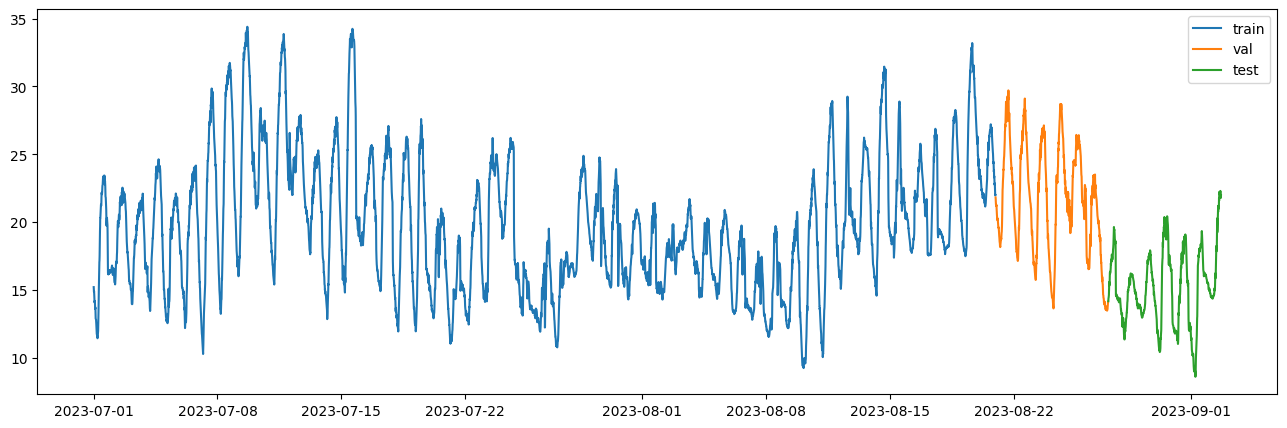

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(tr,label="train")
ax.plot(vl,label="val")
ax.plot(ts,label="test")
plt.legend();

**Adecuación para una red LSTM: Dataset supervisado**

Ajustaremos nuestros sets de entrenamiento, validación y prueba al formato requerido por la Red LSTM para realizar el entrenamiento y posteriormente calcularemos las predicciones.  
Para este modelo, puntualmente ingresaremos al mismo registros continuos de 240 minutos (4 horas = 14400 segundos) para la variable temperatura y el modelo deberá aprender a predecir 10 min a futuro (600seg)  

Debemos estructurar nuestros sets de la siguiente manera:  

*Entrada (X):* arreglo de tamaño batches x input_length x features  
*Salida (Y):* arreglo de tamaño batches x output_length x features

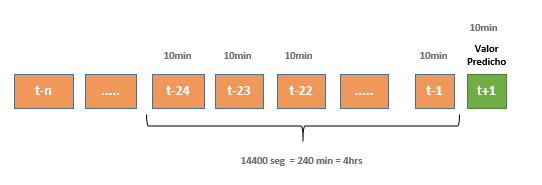

donde:

**batches** es el número total de datos de entrada y de salida. Por ejemplo, el set de entrenamiento tiene un total de 7338 datos pero estos deberán ser divididos en bloques consecutivos de 25 registros (240 minutos de entrada + 10 minutos de salida). Cada uno de estos bloques será un dato de entrenamiento y los batches serán simplemente el número total de bloques de 250 minutos.  
**input_length** es el número de registros consecutivos que usaremos a la entrada del modelo. En nuestro caso este valor es igual a 24 (240 min (24 regx10min)) y esto se convertirá en un hiperparámetro del modelo que se podrá modificar y que impactará el desempeño del modelo obtenido.  
**features** es simplemente el número de variables de entrada o de salida que usaremos. Como estamos usando un enfoque univariado y a la salida haremos la predicción únicamente de la variable temperatura, en ambos casos tendremos features = 1  
**output_length** es el número de horas a futuro que queremos predecir con el modelo. Por tratarse de un enfoque unistep, en este caso tendremos output_length = 1

Teniendo en cuenta lo anterior, podemos concluir que cada subset (entrenamiento, validación y prueba) deberá ser pre-procesado para obtener los arreglos X (entradas) y Y (salidas) los cuales tendrán estos tamaños:  

X: batches x 24 x 1  
Y: batches x 1 x 1  

Creamos la función para el procesamiento necesario

In [ ]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos (utilizando ventanas deslizantes de longitud input_length)
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 240 min consecutivos a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 10 min a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

Visualizamos el tamaño de los arreglos generados:

In [ ]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (7313, 24, 1), y_tr: (7313, 1, 1)
Set de validación - x_vl: (892, 24, 1), y_vl: (892, 1, 1)
Set de prueba - x_ts: (893, 24, 1), y_ts: (893, 1, 1)


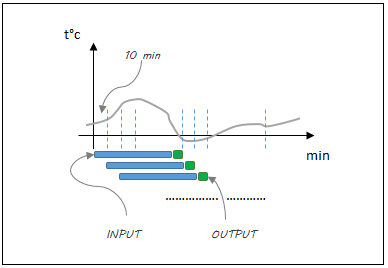

Cada dato de entrenamiento, validación y prueba tendrá un tamaño de 24x1 (INPUT_LENGTH x FEATURES) para la entrada y de 1x1 (OUTPUT_LENGTH x FEATURES) para la salida.

**Escalamiento de los datos**

Es recomendable, al utilizar modelos de deep learning, asegurar que las variables que alimentan el modelo se encuentran en el mismo rango de valores. (Mejora el algoritmo de predicción y por lo tanto las predicciones)

Lo anterior implica que la Red LSTM será entrenada con valores escalados. Recordar que, una vez entrenado el modelo y al momento de generar las predicciones, tendremos que realizar un escalamiento inverso, llevando las predicciones del rango de -1 a 1 al rango normal de temperaturas.

In [ ]:
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [ ]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [ ]:
data_s, scaler = escalar_dataset(data_in)

In [ ]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [ ]:
#Verificamos...
print(f'Min x_tr/x_vl/x_ts sin escalamiento:  {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'Min y_tr/y_vl/y_ts sin escalamiento:  {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'Max x_tr/x_vl/x_ts sin escalamiento:  {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'Max y_tr/y_vl/y_ts sin escalamiento:  {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento:  9.24/13.47/8.6
Min x_tr/x_vl/x_ts con escalamiento:  -0.9999999999999999/-0.6637519872813988/-1.0508744038155802
Min y_tr/y_vl/y_ts sin escalamiento:  9.24/13.47/8.6
Min y_tr/y_vl/y_ts con escalamiento:  -0.9999999999999999/-0.6637519872813988/-1.0508744038155802
Max x_tr/x_vl/x_ts sin escalamiento:  34.4/29.71/22.3
Max x_tr/x_vl/x_ts con escalamiento:  1.0000000000000004/0.6271860095389514/0.03815580286168552
Max y_tr/y_vl/y_ts sin escalamiento:  34.4/29.71/22.3
Max y_tr/y_vl/y_ts con escalamiento:  1.0000000000000004/0.6271860095389514/0.03815580286168552


# Creación y entrenamiento de la Red LSTM

**Creación de la Red LSTM**

Elaboramos la arquitectura principal de la red:

In [ ]:
tf.random.set_seed(123) #para garantizar la reproducibidad del entrenamiento

In [ ]:
#tf.config.experimental.enable_op_determinism() #realizaremos el entrenamiento usando la GPU proporcionada por Google Colab

In [ ]:
N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.
#hiperparámetro del modelo a afinar

In [ ]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) #cada uno de los datos de entrada será un arreglo de tamaño 24 (240 minutos de entrada) x 1 (feature).

In [ ]:
modelo = Sequential() #caja vacía a la cual se le adicionaran de manera secuencial los elementos
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

**Compilación del modelo**

Definimos la función de error a usar durante el entrenamiento así como el optimizador. Es decir, definimos que algoritmo matematico utiizaremos para reducir esa perdida a medida que vanzan las iteraciones.

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [ ]:
optimizador = RMSprop(learning_rate=5e-5)

In [ ]:
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

**Entrenamiento del modelo**

In [ ]:
EPOCHS = 80 #iteraciones de entrenamiento
BATCH_SIZE = 256 #tamaño del lote (es decir, 256 datos de entrenamiento en cada iteración)

Interpretación: Dado que tenemos 7313 ejemplos en en conjunto de entrenamiento y hemos configurado un tamaño de lote de 256, habrá aproximadamente 7313 / 256 = 29   iteraciones en cada época.  

Entonces, durante el entrenamiento con 80 épocas, la red realizará un total de 80 * 29 = 2320 iteraciones a través de tus datos de entrenamiento.  

In [ ]:
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2 #vemos como evoluciona el entrenamiento
)

Epoch 1/80
29/29 - 7s - loss: 0.3542 - val_loss: 0.2483 - 7s/epoch - 251ms/step
Epoch 2/80
29/29 - 3s - loss: 0.2735 - val_loss: 0.2000 - 3s/epoch - 94ms/step
Epoch 3/80
29/29 - 3s - loss: 0.1963 - val_loss: 0.1532 - 3s/epoch - 95ms/step
Epoch 4/80
29/29 - 3s - loss: 0.1414 - val_loss: 0.1205 - 3s/epoch - 94ms/step
Epoch 5/80
29/29 - 4s - loss: 0.1222 - val_loss: 0.1090 - 4s/epoch - 126ms/step
Epoch 6/80
29/29 - 4s - loss: 0.1123 - val_loss: 0.0999 - 4s/epoch - 127ms/step
Epoch 7/80
29/29 - 3s - loss: 0.1027 - val_loss: 0.0904 - 3s/epoch - 93ms/step
Epoch 8/80
29/29 - 3s - loss: 0.0927 - val_loss: 0.0806 - 3s/epoch - 91ms/step
Epoch 9/80
29/29 - 3s - loss: 0.0829 - val_loss: 0.0702 - 3s/epoch - 92ms/step
Epoch 10/80
29/29 - 4s - loss: 0.0735 - val_loss: 0.0610 - 4s/epoch - 141ms/step
Epoch 11/80
29/29 - 3s - loss: 0.0667 - val_loss: 0.0556 - 3s/epoch - 109ms/step
Epoch 12/80
29/29 - 3s - loss: 0.0636 - val_loss: 0.0536 - 3s/epoch - 94ms/step
Epoch 13/80
29/29 - 3s - loss: 0.0624 - val_

Al completar las 80 iteraciones de entrenamiento podremos generar una gráfica de la variable historia para obtener las curvas del comportamiento de la pérdida con los sets de entrenamiento y validación.

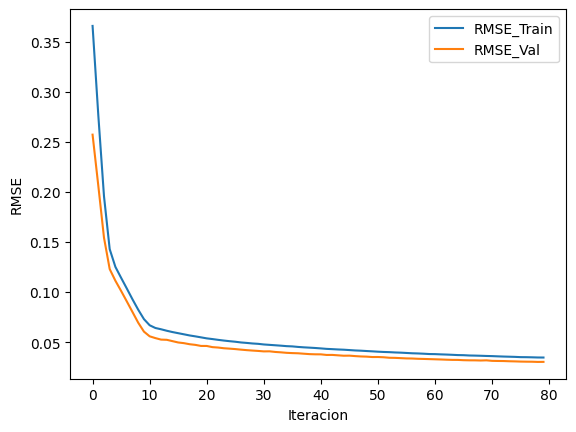

In [ ]:
plt.plot(historia.history['loss'],label='RMSE_Train')
plt.plot(historia.history['val_loss'],label='RMSE_Val')
plt.xlabel('Iteracion')
plt.ylabel('RMSE')
plt.legend();

La pérdida se reduce progresivamente en ambos casos a medida que aumentan las iteraciones  
El nivel de pérdida en la iteración 80 es similar en ambos casos.  
No se observa Overfitting  
*Cómo le harían un fine tuning al modelo???*

**Desempeño del Modelo**

Ahora, verificaremos el desempeño del modelo usando el set de datos que hasta el momento no hemos presentado a la Red: el set de prueba.

In [ ]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

In [ ]:
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.030
  RMSE val:	 0.029
  RMSE test:	 0.024


Los RMSEs obtenidos son comparables el modelo generaliza bastante bien (genera predicciones adecuadas sobre un set de datos que no había visto previamente)

**Predicciones (forecasting) con el modelo entrenado**

In [ ]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [ ]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

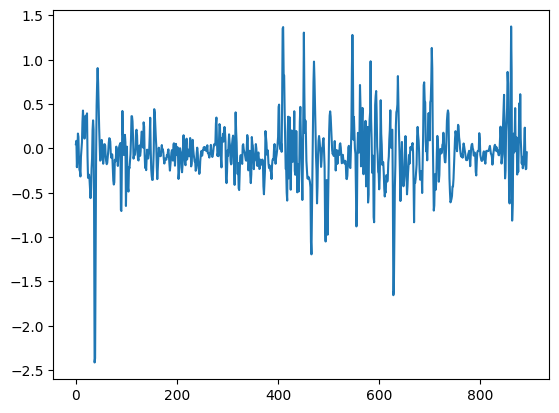

In [ ]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

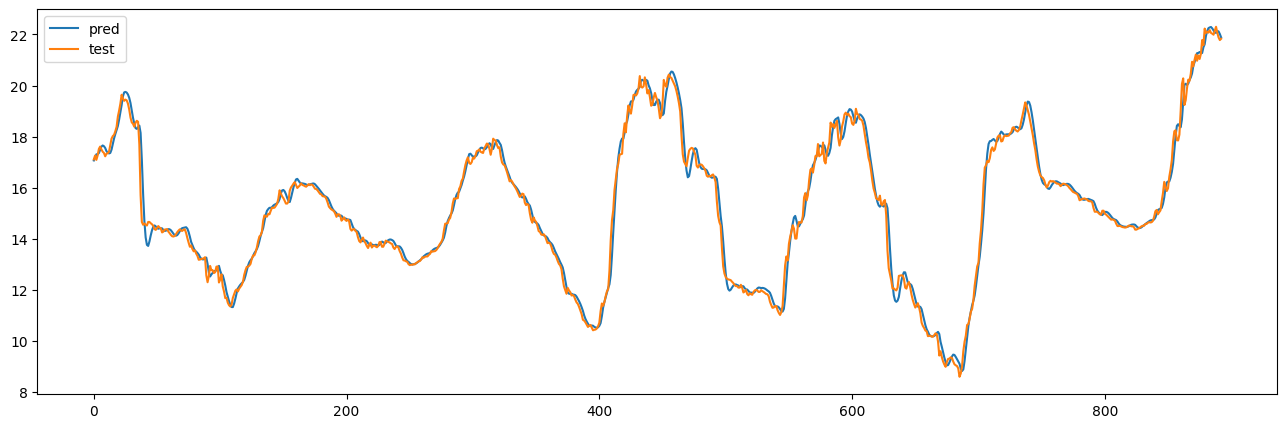

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();

Libros recomendados y fuente del ejercicio adaptado:

Deep Learning with Python, 2nd Edition (Final Release) (Francois Chollet  [Chollet, François])  
Machine Learning Mastery - Long-short-term-memory-networks-with-python  
**Fuente** para profundización, variantes del modelo y desarrollos: https://www.youtube.com/watch?v=R8MEPGn9sFI